<div class="alert alert-block alert-success"><font color="black"><h1><left>Setup Work For MIMIC Model Creation For Intestinal Model</left></h1></font><P>
<font size="5">- Balance Outcomes</font><P>
<font size="5">- Train/Test/Val Split</font></div>

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# Notebook Global Variables
# This is replaced with c;lass definitions in initial spreadsheet
icd_category = ['Colitis','Gastritis','Reflux', 'Heart']
icd_codes = ['K51.90','K29.90','K21.9','I27.89']
group_type = 'indiv'


In [3]:
path = 'E:\Education\DataScience\CCSU-Data-Science\Data-Mining-And-Predictive-Analytics\Data-532\Data\\'
file1 = path + 'pd_notes_clean.snappy.parquet'
file2 = path + 'discharge_notes_clean.snappy.parquet'
# file3 = path + 'base_adms.snappy.parquet'
# file4 = path + 'pd_notes.snappy.parquet'

In [4]:
# Read data and examine counts
# Consistency between pn_notes and bas_adms shows I can eliminate base adm processing now that 
# segmentizing was removed from here and delegated to Hugging Face API
pn_notes = pd.read_parquet(file1,engine='auto',use_nullable_dtypes=True)
print('Admissions in pn notes: ', pn_notes.shape[0], 'Unique admissions: ', len(pn_notes['hadm_id'].unique()))
# print(pn_notes[0:3])
discharge_notes = pd.read_parquet(file2,engine='auto',use_nullable_dtypes=True)
print('Admissions in discharge notes: ', discharge_notes.shape[0], 'Unique discharge admissions: ', len(discharge_notes['hadm_id'].unique()))
# discharge_notes[0:3]
#base_adms = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)
#print('Admissions in base notes: ', base_adms.shape[0], 'Unique base admissions: ', len(base_adms['hadm_id'].unique()))
# base_adms[0:3]



Admissions in pn notes:  2289 Unique admissions:  2289
Admissions in discharge notes:  6027 Unique discharge admissions:  5504


In [5]:
pn_notes.columns

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'text', 'note_length'],
      dtype='object')

In [6]:
# count output diagnosis codes
pn_notes.groupby('icd_category')['hadm_id'].count()

icd_category
Colitis       129
Gastritis     103
Heart         695
IBS            33
Reflux       1212
Ulcer         117
Name: hadm_id, dtype: int64

In [7]:
# This cell is added to performe special selection needs priuor to balancing
# for example to set a classes range prior to balancing to produce similar distribution on note size



if group_type == 'indiv':
    temp_table = icd_codes
    pn_notes_cla = pn_notes[(pn_notes.primary_icd10_code == temp_table[0]) & (pn_notes.note_length < 100000)]
    print(pn_notes_cla.shape)
    pn_notes_clb = pn_notes[(pn_notes.primary_icd10_code == temp_table[1]) & (pn_notes.note_length < 100000)]
    print(pn_notes_clb.shape)
    pn_notes_clc = pn_notes[(pn_notes.primary_icd10_code == temp_table[2]) & (pn_notes.note_length < 100000)]
    print(pn_notes_clc.shape)
    pn_notes_cld = pn_notes[(pn_notes.primary_icd10_code == temp_table[3]) & (pn_notes.note_length < 100000)]
    print(pn_notes_cld.shape)
else:
    temp_table = icd_category
    pn_notes_cla = pn_notes[(pn_notes.icd_category == temp_table[0]) & (pn_notes.note_length < 100000)]
    print(pn_notes_cla.shape)
    pn_notes_clb = pn_notes[(pn_notes.icd_category == temp_table[1]) & (pn_notes.note_length < 100000)]
    print(pn_notes_clb.shape)
    pn_notes_clc = pn_notes[(pn_notes.icd_category == temp_table[2]) & (pn_notes.note_length < 100000)]
    print(pn_notes_clc.shape)
    pn_notes_cld = pn_notes[(pn_notes.icd_category == temp_table[3]) & (pn_notes.note_length < 100000)]
    print(pn_notes_cld.shape)


class_train = pd.concat([pn_notes_cla, pn_notes_clb, pn_notes_clc, pn_notes_cld])
print(class_train.shape)
class_train.groupby(['icd_category'])\
                 .agg(min=('note_length', 'min'), median=('note_length','median'),\
                  max=('note_length','max') , count=('hadm_id','count'))

(51, 20)
(59, 20)
(1121, 20)
(557, 20)
(1788, 20)


,min,median,max,count
icd_category,,,,
Colitis,792,8265.0,88904,51
Gastritis,495,7399.0,89835,59
Heart,397,8500.0,99480,557
Reflux,235,6152.0,99969,1121


In [8]:
# print(class_a.shape)
# print(class_b.shape)
# print(class_c.shape)
# print(class_d.shape)


In [9]:
# Opposed to other authors I did splitting first

class_a_id = pn_notes_cla.hadm_id
class_b_id = pn_notes_clb.hadm_id
class_c_id = pn_notes_clc.hadm_id
class_d_id = pn_notes_cld.hadm_id


# class_a_id = pn_notesb[pn_notesb.primary_icd10_code.isin(icd10_class_def[0])].hadm_id
# class_b_id = pn_notesb[pn_notesb.primary_icd10_code.isin(icd10_class_def[1])].hadm_id

# split train/test/val
# test
class_a_test = class_a_id.sample(frac=0.20, random_state=1)
class_b_test = class_b_id.sample(frac=0.20, random_state=1)
class_c_test = class_c_id.sample(frac=0.20, random_state=1)
class_d_test = class_d_id.sample(frac=0.20, random_state=1)

# train
class_a_train = class_a_id.drop(class_a_test.index)
class_b_train = class_b_id.drop(class_b_test.index)
class_c_train = class_c_id.drop(class_c_test.index)
class_d_train = class_d_id.drop(class_d_test.index)

# split test and val
class_a_val = class_a_test.sample(frac=0.5, random_state=1)
class_a_test = class_a_test.drop(class_a_val.index)
class_b_val = class_b_test.sample(frac=0.5, random_state=1)
class_b_test = class_b_test.drop(class_b_val.index)
class_c_val = class_c_test.sample(frac=0.5, random_state=1)
class_c_test = class_c_test.drop(class_c_val.index)
class_d_val = class_d_test.sample(frac=0.5, random_state=1)
class_d_test = class_d_test.drop(class_d_val.index)


In [10]:
print(class_a_train.shape)
print(class_a_test.shape)
print(class_a_val.shape)
print(class_b_train.shape)
print(class_b_test.shape)
print(class_b_val.shape)
print(class_c_train.shape)
print(class_c_test.shape)
print(class_c_val.shape)
print(class_d_train.shape)
print(class_d_test.shape)
print(class_d_val.shape)


(41,)
(5,)
(5,)
(47,)
(6,)
(6,)
(897,)
(112,)
(112,)
(446,)
(55,)
(56,)


In [11]:
# Rebalance

class_a_train_rs = class_a_train.sample(n=75, replace=True, random_state=1)
class_b_train_rs = class_b_train.sample(n=75, replace=True, random_state=1)
class_c_train_rs = class_c_train.sample(n=75, replace=True, random_state=1)
class_d_train_rs = class_d_train.sample(n=75, replace=True, random_state=1)

class_a_sample_size = int(len(class_a_train_rs) * .15)
class_b_sample_size = int(len(class_a_train_rs) * .13)
class_c_sample_size = int(len(class_a_train_rs) * .15)
class_d_sample_size = int(len(class_a_train_rs) * .15)


class_a_test_rs = class_a_test.sample(n=class_a_sample_size, replace=True, random_state=1)
class_b_test_rs = class_b_test.sample(n=class_b_sample_size, replace=True, random_state=1)
class_c_test_rs = class_c_test.sample(n=class_c_sample_size, replace=True, random_state=1)
class_d_test_rs = class_d_test.sample(n=class_d_sample_size, replace=True, random_state=1)


class_a_val_rs = class_a_val.sample(n=class_a_sample_size, replace=True, random_state=1)
class_b_val_rs = class_b_val.sample(n=class_b_sample_size, replace=True, random_state=1)
class_c_val_rs = class_c_val.sample(n=class_c_sample_size, replace=True, random_state=1)
class_d_val_rs = class_d_val.sample(n=class_d_sample_size, replace=True, random_state=1)



In [12]:
class_a_train.shape
class_b_train.shape
class_c_train.shape
class_d_train.shape
# class_b_val_rs[1:5]

(446,)

In [13]:
# check balancing
df_list = [class_a_train_rs, class_b_train_rs, class_c_train_rs, class_d_train_rs]
print('train')
for x in df_list:
    print('size : ', len(x))


df_listb = [class_a_test_rs, class_b_test_rs, class_c_test_rs, class_d_test_rs]
print('test')
for x in df_listb:
    print('size : ', len(x))

df_listc = [class_a_val_rs, class_b_val_rs, class_c_val_rs, class_d_val_rs]
print('val')
for x in df_listc:
    print('size : ', len(x))


train
size :  75
size :  75
size :  75
size :  75
test
size :  11
size :  9
size :  11
size :  11
val
size :  11
size :  9
size :  11
size :  11


In [14]:
# concatenate and test size and look for any overlap between test and train
train_df_list = [class_a_train_rs, class_b_train_rs,class_c_train_rs, class_d_train_rs]
id_train_df = pd.concat(train_df_list)

test_df_list = [class_a_test_rs, class_b_test_rs, class_c_test_rs, class_d_test_rs]
id_test_df = pd.concat(test_df_list)

val_df_list = [class_a_val_rs, class_b_val_rs,class_c_val_rs, class_d_val_rs]
id_val_df = pd.concat(val_df_list)

print('train size: ', id_train_df.shape[0])
print('test size: ', id_test_df.shape[0])
print('val size: ', id_val_df.shape[0])
 
# check between train and test
(pd.Index(id_test_df).intersection(pd.Index(id_train_df))).values

# print('between 25.0')
# (pd.Index(k25_0_train).intersection(pd.Index(k25_0_test))).values

# print('between 25.4')
# (pd.Index(k25_4_train).intersection(pd.Index(k25_4_test))).values

# print('between 29.90')
# (pd.Index(k29_90_train).intersection(pd.Index(k29_90_test))).values

# print('between 29.91')
# (pd.Index(k29_91_train).intersection(pd.Index(k29_91_test))).values

# print('between 51.00')
# (pd.Index(k51_00_train).intersection(pd.Index(k51_00_test))).values

# print('between 51.90')
# (pd.Index(k51_90_train).intersection(pd.Index(k51_90_test))).values

# print('between 52.9')
# (pd.Index(k52_9_train).intersection(pd.Index(k52_9_test))).values

# print('between 56.60')
# (pd.Index(k56_60_train).intersection(pd.Index(k56_60_test))).values

# print('between 56.69')
# (pd.Index(k56_69_train).intersection(pd.Index(k56_69_test))).values

# print('between 58.9')
# (pd.Index(k58_9_train).intersection(pd.Index(k58_9_test))).values




train size:  300
test size:  42
val size:  42


array([], dtype=object)

In [15]:
def create_label(code):
    
    temp_val = 0

    if group_type == 'indiv':
        item_table = icd_codes
    else:
        item_table = icd_category
      
    if code in item_table[0]:
        temp_val = 0
    elif code in item_table[1]:
        temp_val = 1
    elif code in item_table[2]:
        temp_val = 2
    elif code in item_table[3]:
        temp_val = 3
    else:
        temp_val = 99
        
    
    return(temp_val)


id_train_df = pd.DataFrame(id_train_df)
intsl_train = pd.merge(id_train_df, pn_notes, left_on=['hadm_id'], right_on=['hadm_id'], how='left')
#intsl_train = intsl_train.rename(columns={'hadm_id_x': 'hadm_id'})
#intsl_train = intsl_train.drop('hadm_id_y', axis = 1)
if group_type == 'indiv':
    intsl_train['label'] = intsl_train['primary_icd10_code'].map(create_label).astype('category')
else:
    intsl_train['label'] = intsl_train['icd_category'].map(create_label).astype('category')
intsl_train['hadm_id'] = intsl_train['hadm_id'].astype('Int64')
intsl_train['text'] = intsl_train['text'].astype('string')
print('train', intsl_train.columns)

id_test_df = pd.DataFrame(id_test_df)
intsl_test = pd.merge(id_test_df, pn_notes, left_on=['hadm_id'], right_on=['hadm_id'], how='left')
# intsl_test = intsl_test.rename(columns={'hadm_id_x': 'hadm_id'})
# intsl_test = intsl_test.drop('hadm_id_y', axis = 1)
if group_type == 'indiv':
    intsl_test['label'] = intsl_test['primary_icd10_code'].map(create_label).astype('category')
else:
    intsl_test['label'] = intsl_test['icd_category'].map(create_label).astype('category')
intsl_test['adm_id'] = intsl_test['hadm_id'].astype('Int64')
intsl_test['text'] = intsl_test['text'].astype('string')

print('test', intsl_test.columns)

id_val_df = pd.DataFrame(id_val_df)
intsl_val = pd.merge(id_val_df, pn_notes, left_on=['hadm_id'], right_on=['hadm_id'], how='left')
if group_type == 'indiv':
    intsl_val['label'] = intsl_val['primary_icd10_code'].map(create_label).astype('category')
else:
    intsl_val['label'] = intsl_val['icd_category'].map(create_label).astype('category')
intsl_val['hadm_id'] = intsl_val['hadm_id'].astype('Int64')
intsl_val['text'] = intsl_val['text'].astype('string')
intsl_val['label'] = intsl_val['label'].astype('category')
print('val', intsl_val.columns)

# early_test.to_csv('./data/3days/test.csv')

train Index(['hadm_id', 'subject_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'text', 'note_length', 'label'],
      dtype='object')
test Index(['hadm_id', 'subject_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'text', 'note_length', 'label', 'adm_id'],
      dtype='object')
val Index(['hadm_id', 'subject_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', '

In [16]:
# if roland == 7
#   print(7)
# intsl_train.columns
intsl_train.groupby(['icd_category', 'label'])['hadm_id'].count()

icd_category  label
Colitis       0        75
              1         0
              2         0
              3         0
Gastritis     0         0
              1        75
              2         0
              3         0
Heart         0         0
              1         0
              2         0
              3        75
Reflux        0         0
              1         0
              2        75
              3         0
Name: hadm_id, dtype: int64

In [17]:
pd.set_option('display.max_rows', 500)
intsl_train.groupby(['primary_icd10_code','label'])['hadm_id'].count()

primary_icd10_code  label
I27.89              0         0
                    1         0
                    2         0
                    3        75
K21.9               0         0
                    1         0
                    2        75
                    3         0
K29.90              0         0
                    1        75
                    2         0
                    3         0
K51.90              0        75
                    1         0
                    2         0
                    3         0
Name: hadm_id, dtype: int64

In [18]:
intsl_train = intsl_train[['hadm_id', 'text', 'primary_icd10_code', 'label']]\
                     .rename(columns={'hadm_id':'id', 'primary_icd10_code':'icd10_code'})
intsl_test = intsl_test[['hadm_id', 'text', 'primary_icd10_code', 'label']]\
                     .rename(columns={'hadm_id':'id', 'primary_icd10_code':'icd10_code'})
intsl_val = intsl_val[['hadm_id', 'text', 'primary_icd10_code', 'label']]\
                     .rename(columns={'hadm_id':'id', 'primary_icd10_code':'icd10_code'})
print(intsl_train[1:5])
print(intsl_test[1:5])
print(intsl_val[1:5])

       id                                               text icd10_code label
1  116655  micu nursing progress note. - please see carev...     K51.90     0
2  180273  tsicu nursing progress note neuro: pt a&o x pt...     K51.90     0
3  192855  respiratory care: pt. intubated secondary to w...     K51.90     0
4  178857  ccu nursing progress note pls see fhpa for det...     K51.90     0
       id                                               text icd10_code label
1  109151  chief complaint: diarrhea, rigors hpi: ms. is ...     K51.90     0
2  108130  update see careview for details... pt arrived ...     K51.90     0
3  135131  resp care note - intubated pt. transffered fro...     K51.90     0
4  149608  pt adm to cvicu a @ from ed. pt is s/p days po...     K51.90     0
       id                                               text icd10_code label
1  127608  micu nursing progress note - y/o female admitt...     K51.90     0
2  140486  chief complaint: lgib i saw and examined the p...    

In [19]:
print(intsl_train.groupby('label')['id'].count())
print(intsl_test.groupby('label')['id'].count())
print(intsl_val.groupby('label')['id'].count())

label
0    75
1    75
2    75
3    75
Name: id, dtype: int64
label
0    11
1     9
2    11
3    11
Name: id, dtype: int64
label
0    11
1     9
2    11
3    11
Name: id, dtype: int64


In [20]:
print(intsl_train.dtypes)
intsl_train[1:5]

id               Int64
text            string
icd10_code      string
label         category
dtype: object


,id,text,icd10_code,label
1,116655,micu nursing progress note. - please see carev...,K51.90,0
2,180273,tsicu nursing progress note neuro: pt a&o x pt...,K51.90,0
3,192855,respiratory care: pt. intubated secondary to w...,K51.90,0
4,178857,ccu nursing progress note pls see fhpa for det...,K51.90,0


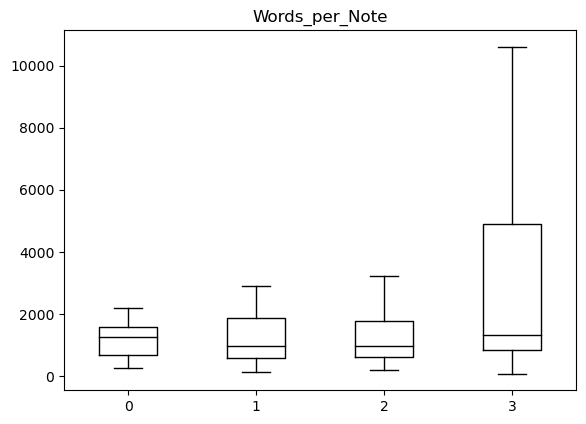

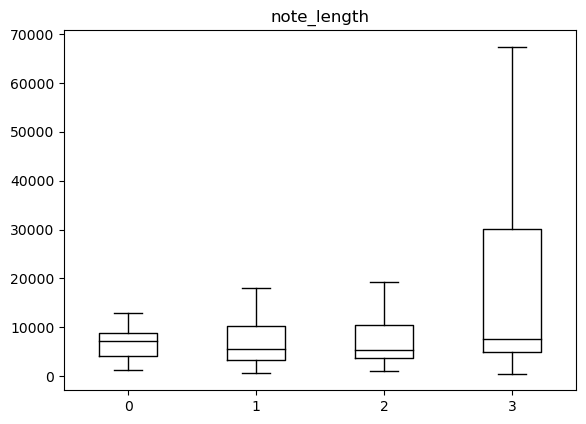

In [21]:
new_df = intsl_train.copy()
new_df['Words_per_Note'] = new_df["text"].str.split().apply(len)
new_df['note_length'] = new_df["text"].apply(len)
# print(intsl_train.columns)
new_df.boxplot('Words_per_Note', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel("")
plt.show()
new_df.boxplot('note_length', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel("")
plt.show()



In [22]:
"""  This is extra as an example of pansql

import pandasql as ps

#qintsl = intsl_notes[['subject_id', 'hadm_id']]
# print(qintsl.dtypes)
a1 = "SELECT avg(text_length) FROM \ 
        (select len(text) as text_len from id_train_df) as a "
        

l1 = ps.sqldf(a1, locals())
print(l1) """

'  This is extra as an example of pansql\n\nimport pandasql as ps\n\n#qintsl = intsl_notes[[\'subject_id\', \'hadm_id\']]\n# print(qintsl.dtypes)\na1 = "SELECT avg(text_length) FROM \\ \n        (select len(text) as text_len from id_train_df) as a "\n        \n\nl1 = ps.sqldf(a1, locals())\nprint(l1) '

In [23]:
intsl_train[['id','text', 'icd10_code','label']].groupby(['label'])['id'].count()


label
0    75
1    75
2    75
3    75
Name: id, dtype: int64

<div class="alert alert-block alert-success"><font color="black"><h1><left>Write File with Admission Details and Attached Combined Notes</left></h1></font></div>

In [24]:
path = 'E://Education//DataScience/CCSU-Data-Science/Data-Mining-And-Predictive-Analytics/Data-532/Data/'
fname = 'intsl_train_indiv_no2.snappy.parquet'
f2name = 'intsl_test_indiv_no2.snappy.parquet'
f3name = 'intsl_val_indiv_no2.snappy.parquet'

intsl_train.to_parquet(path + fname,compression='snappy',index=None)  
intsl_test.to_parquet(path + f2name,compression='snappy',index=None)  
intsl_val.to_parquet(path + f3name,compression='snappy',index=None)  


In [25]:
import boto3, os
s3 = boto3.resource('s3')
S3_path = 'MIMIC/Data/' + fname
S3_path2 = 'MIMIC/Data/' + f2name
S3_path3 = 'MIMIC/Data/' + f3name
out_file = path + fname
out_file2 = path + f2name
out_file3 = path + f3name

In [26]:
s3.meta.client.upload_file(out_file, 'depratti-masters-thesis', S3_path)
s3.meta.client.upload_file(out_file2, 'depratti-masters-thesis', S3_path2)
s3.meta.client.upload_file(out_file3, 'depratti-masters-thesis', S3_path3)

In [27]:
print(intsl_train.shape)
print(intsl_test.shape)
print(intsl_val.shape)
print(intsl_val.columns)

(300, 4)
(42, 4)
(42, 4)
Index(['id', 'text', 'icd10_code', 'label'], dtype='object')


In [28]:
intsl_train.groupby(['icd10_code', 'label'])['id'].count()

icd10_code  label
I27.89      0         0
            1         0
            2         0
            3        75
K21.9       0         0
            1         0
            2        75
            3         0
K29.90      0         0
            1        75
            2         0
            3         0
K51.90      0        75
            1         0
            2         0
            3         0
Name: id, dtype: int64